In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
#trans_full.head()

# Filter Dataset:

### _ONLY ITALY

In [5]:

trans_it = trans_full.loc[trans_full['country'] == 'IT']
trans_it = trans_it.sort_values('Date', ascending = True)
trans_it = trans_it.drop(['country'], axis = 1)
#trans_it.head()

### _RTI = Container Base

In [6]:
it_cb = trans_it.loc[trans_it['T_RTI_NAME'] == 'CC Container Base']
it_cb = it_cb.drop(['T_RTI_NAME'], axis = 1)
it_cb['Date'] = pd.to_datetime(it_cb['Date'])
it_cb = it_cb.set_index('Date')
it_cb.head()

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-07-07,22,I 48 Latina Floratoscana
2014-07-11,2,I 48 Latina Floratoscana
2014-07-14,18,I 35 Bari Capitanio
2014-07-15,1,I 48 Latina Floratoscana
2014-07-17,50,I 03 Giarre Weistra HUB


Text(0.5, 1.0, 'CB_IT Jul 2014--Jul 2019')

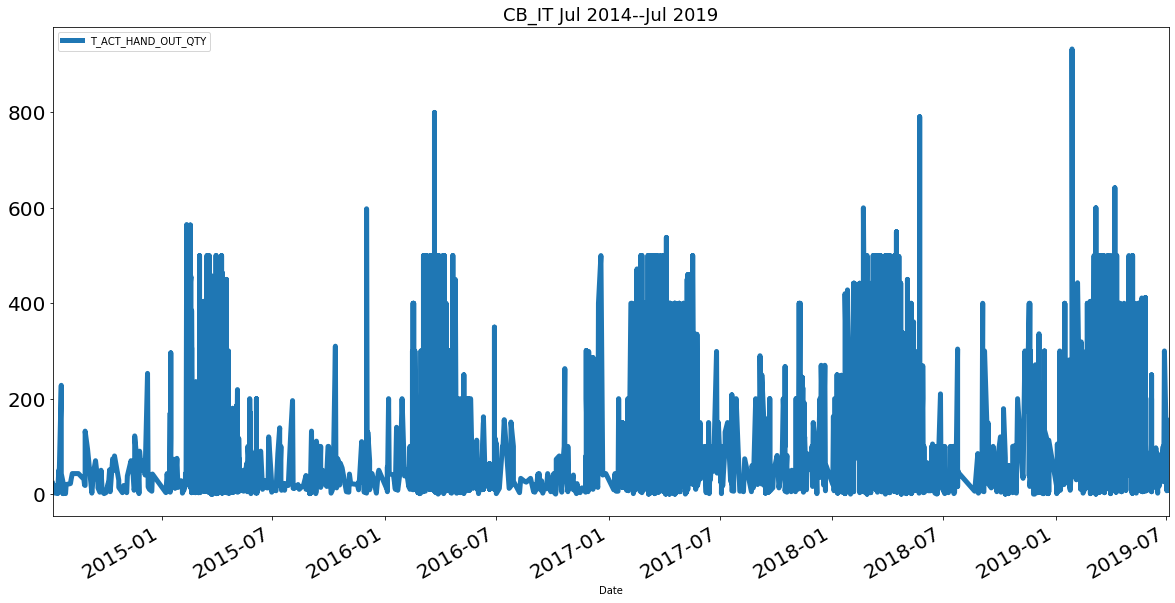

In [7]:
it_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_IT Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2017 on

Text(0.5, 1.0, 'CB_IT : Jan 2017--Jul 2019')

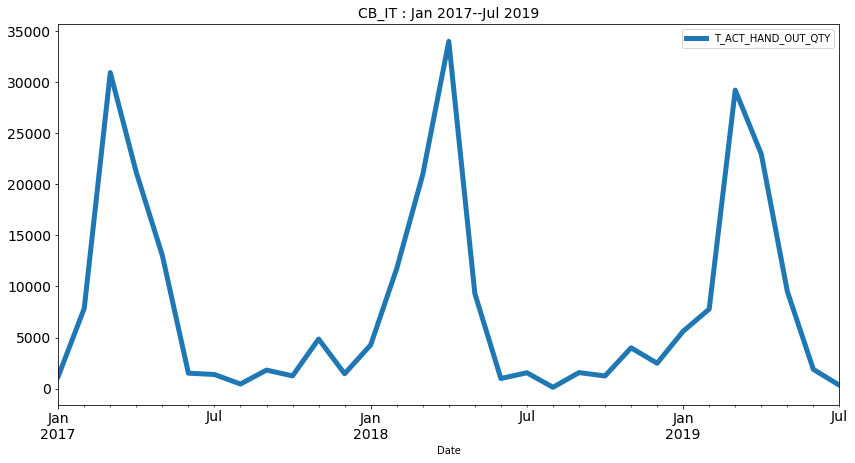

In [8]:
import datetime
it_cbm = it_cb.resample('1M').sum()
it_cb_m = it_cbm[(it_cbm.index >= datetime.datetime(2017,1,31))]
it_cb_m.plot(figsize=(14,7), linewidth=5, fontsize=14)
plt.title("CB_IT : Jan 2017--Jul 2019", fontsize = 14)

## Seasonal Decompose 2017

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(it_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

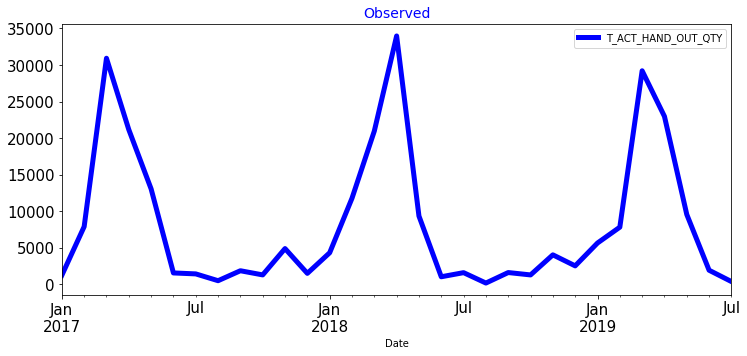

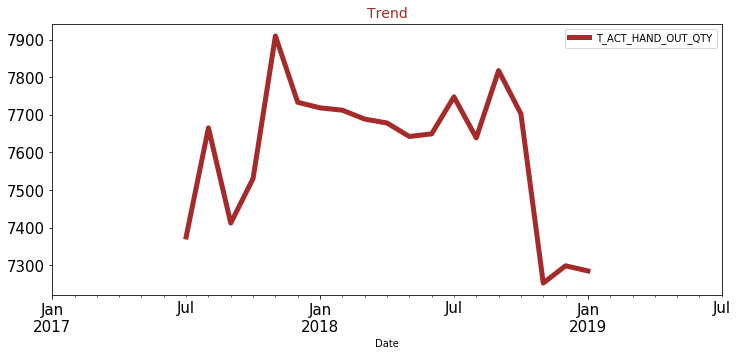

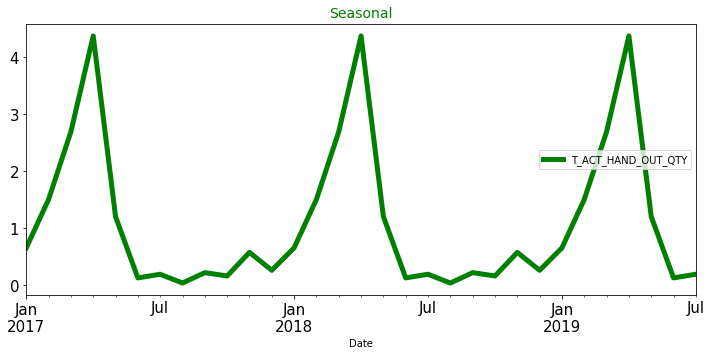

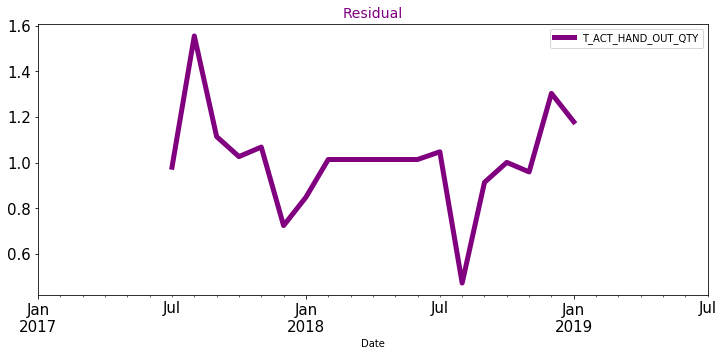

In [10]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [11]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=385.416, BIC=387.197, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=371.304, BIC=374.866, Fit time=0.053 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=383.484, BIC=384.374, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=372.318, BIC=374.989, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


In [12]:
#it_cb_m.index

In [13]:
train = it_cb_m.loc['2017-01-31':'2018-12-31']
test = it_cb_m.loc['2019-01-31':]

In [14]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
future_forecast = stepwise_model.predict(n_periods=7)
future_forecast

array([ 1892.88869656, 11607.01580493, 19985.45919904, 32070.87645796,
        8568.88648753,  -909.53021688,  -206.53404786])

Text(0.5, 1.0, '2019 Prediction of IT-CB')

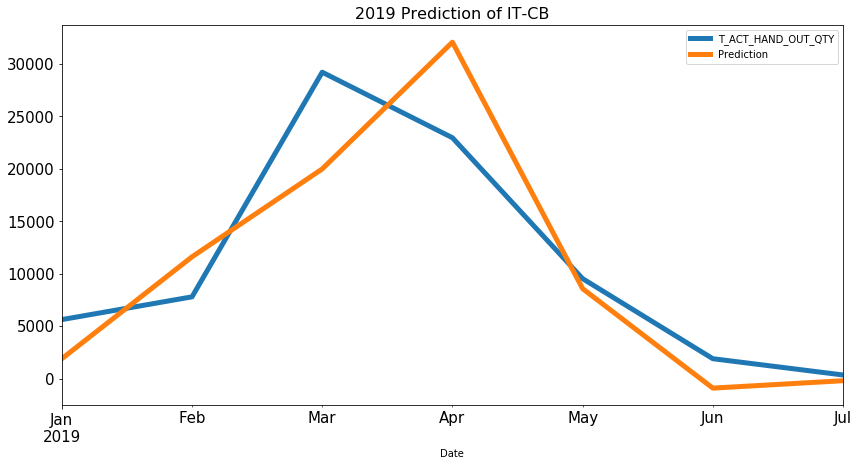

In [16]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction of IT-CB', fontsize = 16)

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

29373328.515663836

In [18]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

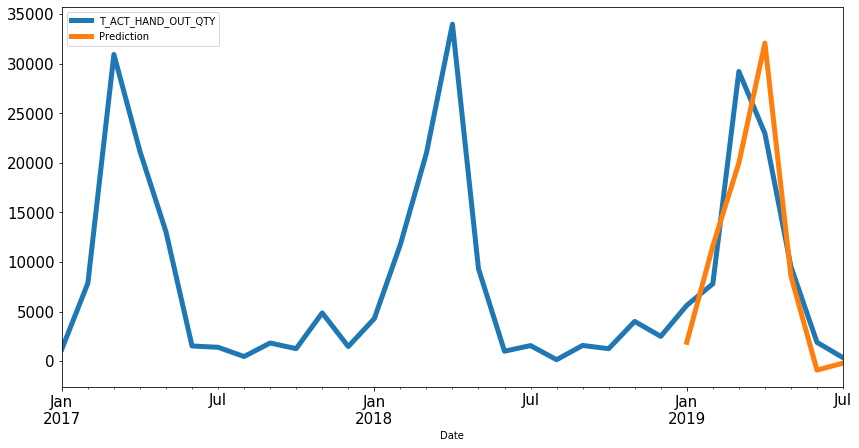

In [19]:
pd.concat([it_cb_m,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

## ARIMA

In [20]:
#from pyramid.arima import auto_arima
stepwise_arimamodel = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_arimamodel.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=642.698, BIC=648.302, Fit time=0.034 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=638.158, BIC=640.960, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=639.849, BIC=644.053, Fit time=0.010 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=639.733, BIC=643.937, Fit time=0.037 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=636.174, BIC=637.575, Fit time=0.003 seconds
Total fit time: 0.091 seconds
636.1740914252784


## d&D = 0

In [21]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=661.807, BIC=664.675, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=648.056, BIC=653.792, Fit time=0.044 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=676.482, BIC=677.916, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=653.220, BIC=657.522, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=649.924, BIC=657.094, Fit time=0.091 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=na

In [22]:
nodiff_fit = nodiff_model.fit(train)

In [23]:
nondiff_forecast = nodiff_fit.predict(n_periods=7)
nondiff_forecast

array([ 5470.9938384 , 10650.46169404, 19039.25036314, 28944.08379049,
        9436.52496398,  1985.36763072,  3021.89296247])

Text(0.5, 1.0, '2019 Prediction of IT-CB')

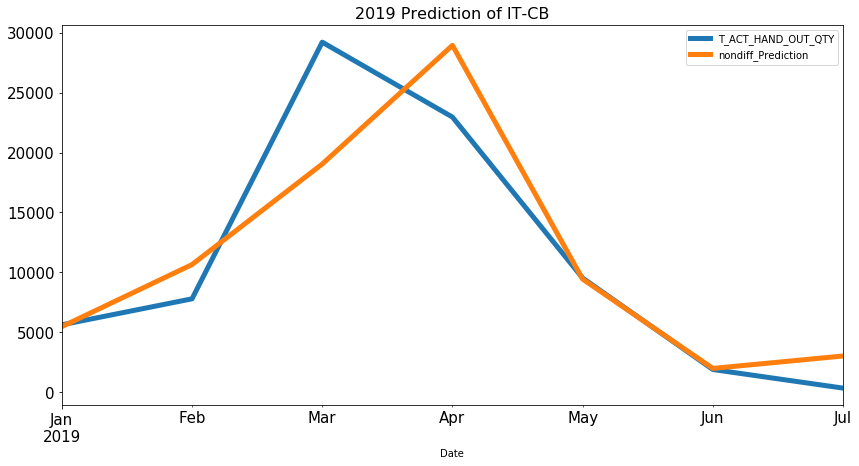

In [24]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['nondiff_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction of IT-CB', fontsize = 16)

In [25]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

22088095.303584542

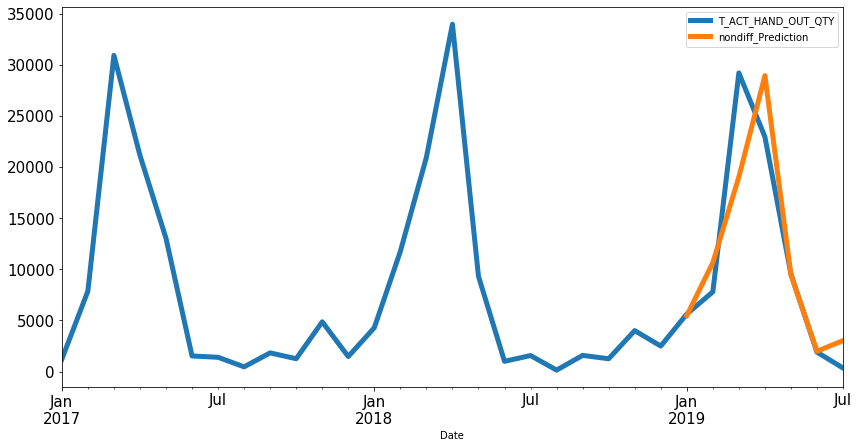

In [26]:
pd.concat([it_cb_m,nondiff_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

## Since Jul 2014

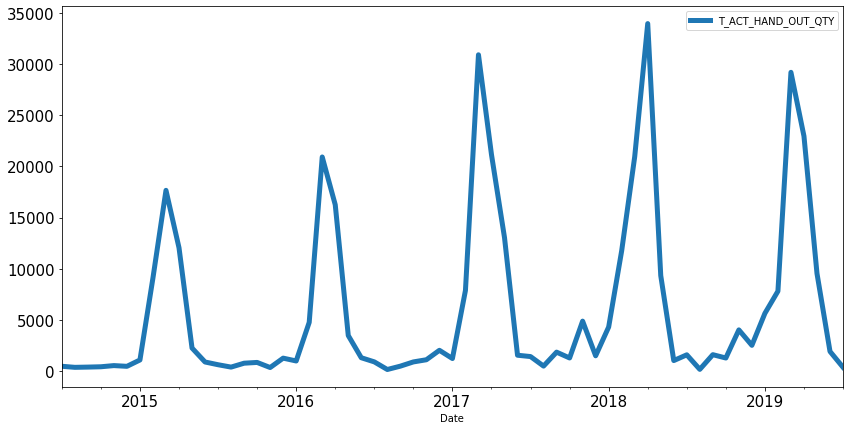

In [27]:
it_cbm.plot(figsize=(14,7), linewidth=5, fontsize=15)

In [28]:
all_model = arima.auto_arima(it_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(all_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=661.807, BIC=664.675, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=648.056, BIC=653.792, Fit time=0.037 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=676.482, BIC=677.916, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=653.220, BIC=657.522, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=649.924, BIC=657.094, Fit time=0.085 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=na

In [29]:
all_train = it_cb_m.loc['2014-07-31':'2018-12-31']
all_test = it_cb_m.loc['2019-01-31':]

In [30]:
all_fit = all_model.fit(all_train)

In [31]:
all_forecast = all_fit.predict(n_periods=7)
all_forecast

array([ 5470.9938384 , 10650.46169404, 19039.25036314, 28944.08379049,
        9436.52496398,  1985.36763072,  3021.89296247])

Text(0.5, 1.0, '2019 Prediction of IT-CB')

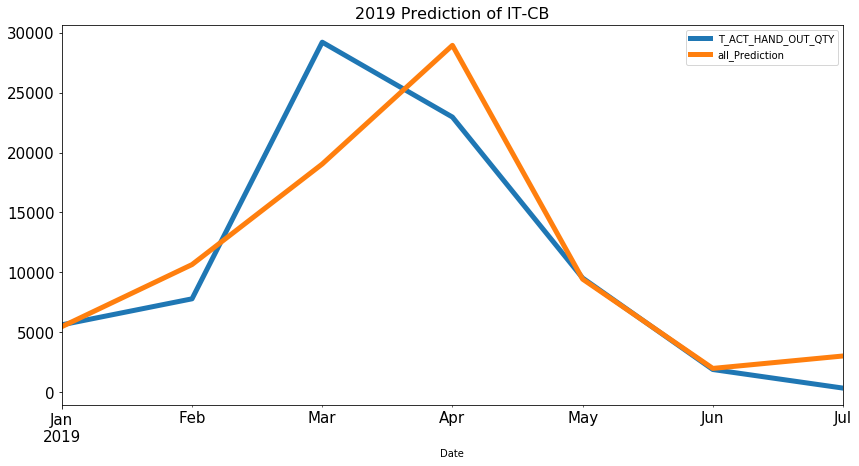

In [32]:
all_forecast = pd.DataFrame(all_forecast,index = test.index,columns=['all_Prediction'])
pd.concat([test,all_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
plt.title('2019 Prediction of IT-CB', fontsize = 16)

In [33]:
all_mse = mean_squared_error(all_test, all_forecast)
all_mse

22088095.303584542

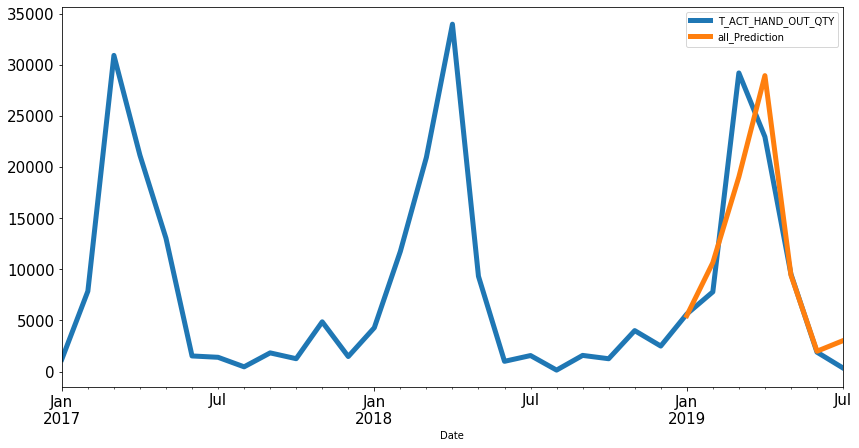

In [34]:
pd.concat([it_cb_m, all_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

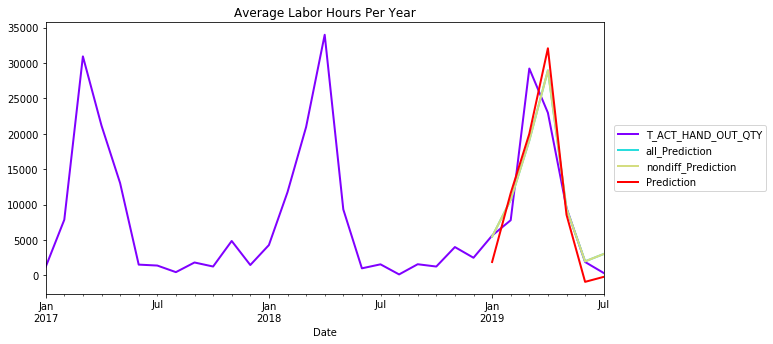

In [35]:
pd.concat([it_cb_m, all_forecast, nondiff_forecast, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Average Labor Hours Per Year')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [36]:
MSEs = [mse, nondiff_mse, all_mse]

In [37]:
norm = [i/sum(MSEs) for i in MSEs]
norm

[0.39936805659610486, 0.30031597170194757, 0.30031597170194757]

In [38]:
MSEs.index(min(MSEs))

1

In [39]:
max(MSEs)

29373328.515663836

In [40]:
mse

29373328.515663836

In [41]:
from math import sqrt
sqrt(mse)

5419.716645329701

In [42]:
nondiff_mse

22088095.303584542

In [43]:
sqrt(nondiff_mse)

4699.797368353719

In [44]:
all_mse

22088095.303584542

In [45]:
sqrt(all_mse)

4699.797368353719

## DEPOTS

In [46]:
trans_it['Date'] = pd.to_datetime(trans_it['Date'])

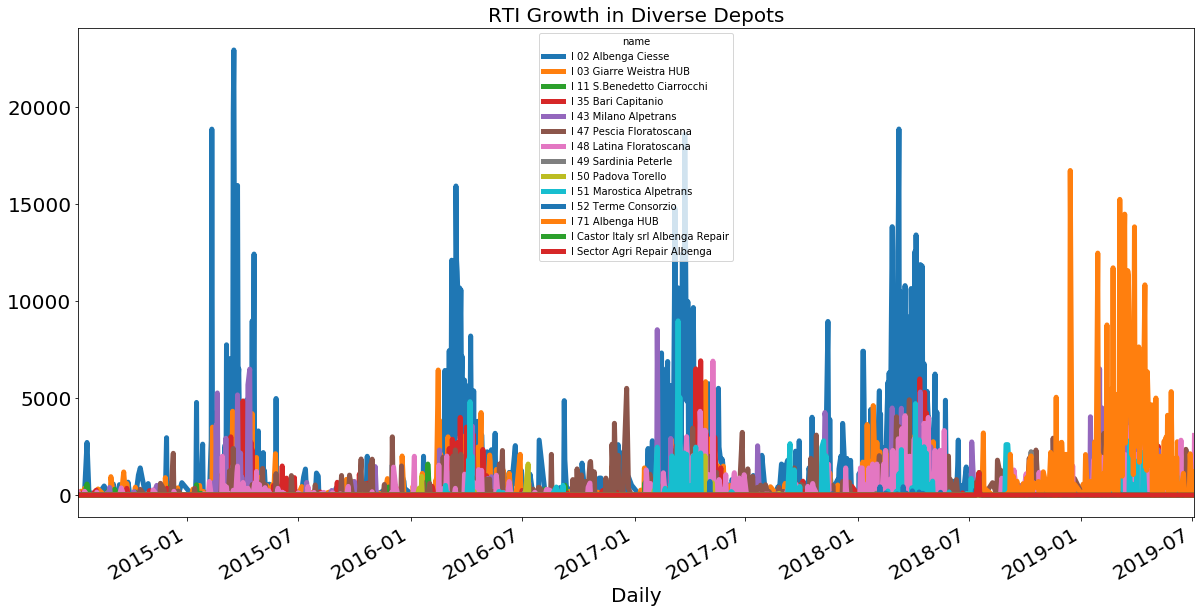

In [47]:
(trans_it.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

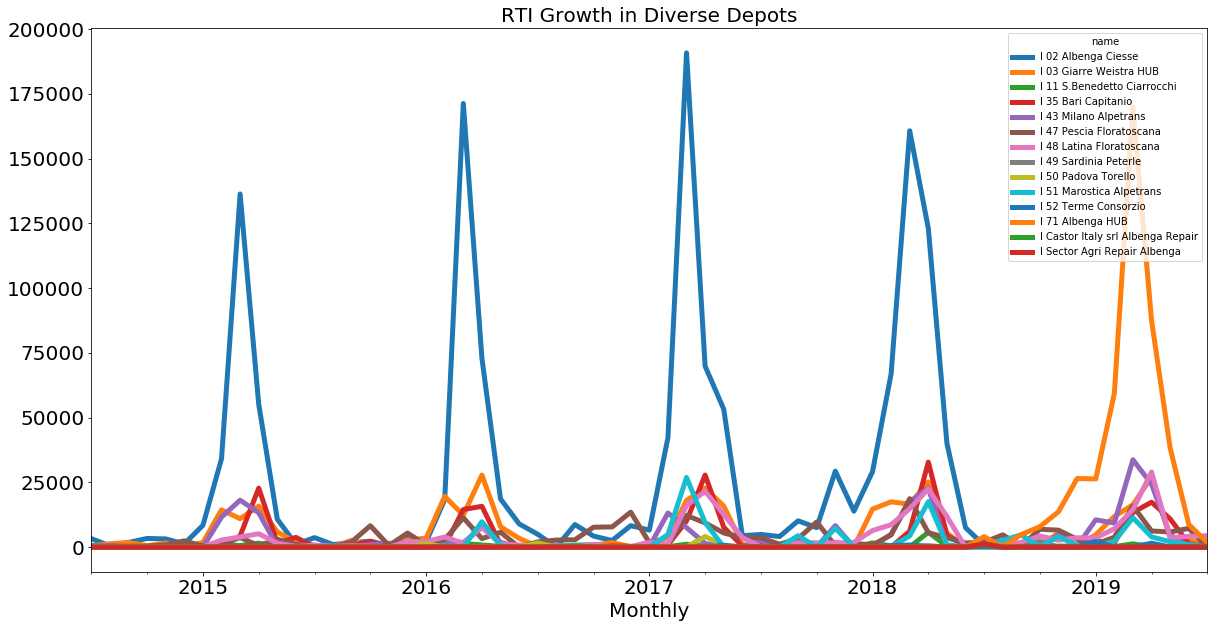

In [48]:
it_deps = trans_it.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
it_deps_month = it_deps.resample('1M').sum()
it_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

Text(0.5, 1.0, 'CB_IT : Jan 2016--Jul 2019')

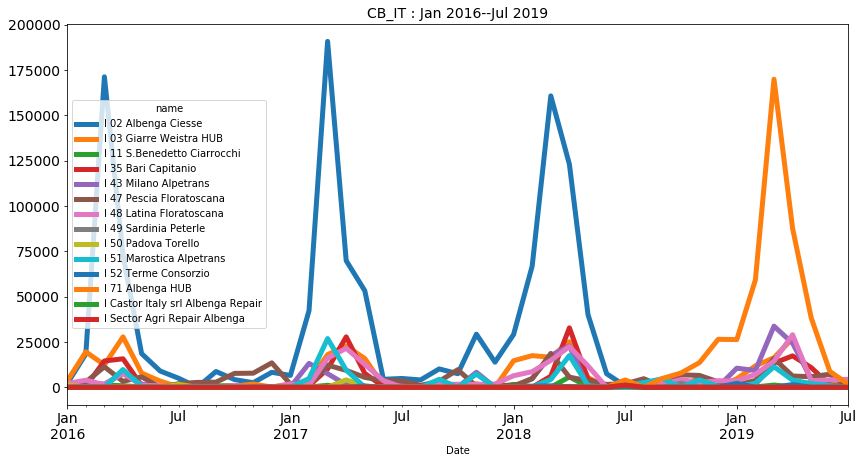

In [49]:
import datetime
it_cb2016 = it_deps_month[(it_cbm.index >= datetime.datetime(2016,1,31))]
it_cb2016.plot(figsize=(14,7), linewidth=5, fontsize=14)
plt.title("CB_IT : Jan 2016--Jul 2019", fontsize = 14)

In [50]:
depos = trans_it['name'].unique()

In [51]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [52]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = it_cb2016[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)


 I 48 Latina Floratoscana: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=740.285, BIC=748.202, Fit time=0.308 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=754.127, BIC=757.295, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=721.955, BIC=728.289, Fit time=0.150 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=738.196, BIC=744.530, Fit time=0.207 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=752.146, BIC=753.729, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=757.013, BIC=763.347, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1,

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 6); AIC=884.062, BIC=893.563, Fit time=0.260 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=877.702, BIC=882.452, Fit time=0.035 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 6); AIC=879.702, BIC=886.036, Fit time=0.058 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=879.702, BIC=886.036, Fit time=0.048 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=885.352, BIC=890.102, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 6); AIC=881.702, BIC=889.619, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=875.955, BIC=882.289, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=906.203, BIC=910.954, Fit time=0.017 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 6); AIC=877.952, BIC=885.869, Fit time=0.064 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 6);

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=727.131, BIC=736.632, Fit time=0.275 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=726.211, BIC=734.129, Fit time=0.226 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=729.027, BIC=735.361, Fit time=0.185 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=733.197, BIC=742.698, Fit time=0.274 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=717.017, BIC=726.518, Fit time=0.304 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the bor

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=577.183, BIC=583.517, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=561.090, BIC=567.424, Fit time=0.143 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=579.179, BIC=580.762, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=574.809, BIC=581.143, Fit time=0.092 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=563.723, BIC=573.224, Fit time=0.237 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=513.067, BIC=519.402, Fit time=0.077 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=507.051, BIC=516.553, Fit time=0.272 seconds
Near non-invertible roots for order (2, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=507.041, BIC=516.542, Fit time=0.196 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=520.978, BIC=525.729, Fit time=0.070 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root

In [53]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = it_cb2016[[depos[f]]].dropna()
    my_train = dep.loc['2016-01-31':'2018-12-31']
    my_test = dep.loc['2019-01-31':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=7)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)

In [54]:
depots_forecasts = pd.DataFrame()

In [55]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]

In [56]:
my_test

name,I 71 Albenga HUB
Date,
2019-01-31,26323
2019-02-28,59259
2019-03-31,169939
2019-04-30,87639
2019-05-31,38320
2019-06-30,8811
2019-07-31,1649


In [57]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

,I 48 Latina Floratoscana,I 03 Giarre Weistra HUB,I 35 Bari Capitanio,I 02 Albenga Ciesse,I 11 S.Benedetto Ciarrocchi,I 43 Milano Alpetrans,I 47 Pescia Floratoscana,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 49 Sardinia Peterle,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga,I 71 Albenga HUB
Date,,,,,,,,,,,,,,
2019-01-31,8327.471115,15955.840090,0.000000,7653.447934,902.175415,318.898300,420.350918,29.633147,0.000000,0.357271,30.354835,1468.009599,1468.009599,30519.0
2019-02-28,10752.468784,18826.626433,0.000000,44447.281168,355.157020,4499.812358,939.069811,0.000000,586.408822,38.210510,177.406712,121.337923,121.337923,26479.0
2019-03-31,17162.956391,17984.933537,3133.790197,137645.235856,768.635203,15626.655977,5094.935845,0.000000,4949.073278,60.583071,181.997307,126.153460,126.153460,31346.0
2019-04-30,24941.466029,26612.103883,28935.547835,99270.190547,1567.079158,20321.411933,3795.540860,169.840879,4094.312043,0.000000,3554.843517,130.968998,130.968998,34364.0
2019-05-31,14484.807792,6984.600749,0.000000,15684.145239,401.314742,1151.998061,1533.923327,0.000000,359.977945,47.601529,193.530867,135.784535,135.784535,40150.0
2019-06-30,2884.631237,1753.226328,0.000000,0.000000,318.047003,414.802802,287.303868,0.000000,0.000000,0.000000,199.290814,140.600066,140.600066,52958.0
2019-07-31,3075.415442,2161.224283,0.000000,0.000000,1000.079693,2981.286799,0.000000,0.000000,0.000000,0.000000,372.852251,1626.942804,1626.942804,56998.0


In [58]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)  

In [59]:
depots_forecasts

,I 48 Latina Floratoscana,I 03 Giarre Weistra HUB,I 35 Bari Capitanio,I 02 Albenga Ciesse,I 11 S.Benedetto Ciarrocchi,I 43 Milano Alpetrans,I 47 Pescia Floratoscana,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 49 Sardinia Peterle,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga,I 71 Albenga HUB
Date,,,,,,,,,,,,,,
2019-01-31,8327.471115,15955.840090,0.000000,7653.447934,902.175415,318.898300,420.350918,29.633147,0.000000,0.357271,30.354835,1468.009599,1468.009599,30519.0
2019-02-28,10752.468784,18826.626433,0.000000,44447.281168,355.157020,4499.812358,939.069811,0.000000,586.408822,38.210510,177.406712,121.337923,121.337923,26479.0
2019-03-31,17162.956391,17984.933537,3133.790197,137645.235856,768.635203,15626.655977,5094.935845,0.000000,4949.073278,60.583071,181.997307,126.153460,126.153460,31346.0
2019-04-30,24941.466029,26612.103883,28935.547835,99270.190547,1567.079158,20321.411933,3795.540860,169.840879,4094.312043,0.000000,3554.843517,130.968998,130.968998,34364.0
2019-05-31,14484.807792,6984.600749,0.000000,15684.145239,401.314742,1151.998061,1533.923327,0.000000,359.977945,47.601529,193.530867,135.784535,135.784535,40150.0
2019-06-30,2884.631237,1753.226328,0.000000,0.000000,318.047003,414.802802,287.303868,0.000000,0.000000,0.000000,199.290814,140.600066,140.600066,52958.0
2019-07-31,3075.415442,2161.224283,0.000000,0.000000,1000.079693,2981.286799,0.000000,0.000000,0.000000,0.000000,372.852251,1626.942804,1626.942804,56998.0


In [60]:
depo_test

[name        I 48 Latina Floratoscana
 Date                                
 2019-01-31                      3491
 2019-02-28                      7099
 2019-03-31                     14450
 2019-04-30                     28998
 2019-05-31                      3649
 2019-06-30                      4124
 2019-07-31                      4410, name        I 03 Giarre Weistra HUB
 Date                               
 2019-01-31                     4732
 2019-02-28                    11820
 2019-03-31                    16333
 2019-04-30                    27006
 2019-05-31                     3535
 2019-06-30                     3006
 2019-07-31                       49, name        I 35 Bari Capitanio
 Date                           
 2019-01-31                  410
 2019-02-28                 1700
 2019-03-31                13363
 2019-04-30                17343
 2019-05-31                10905
 2019-06-30                 1294
 2019-07-31                    0, name        I 02 Albenga Ci

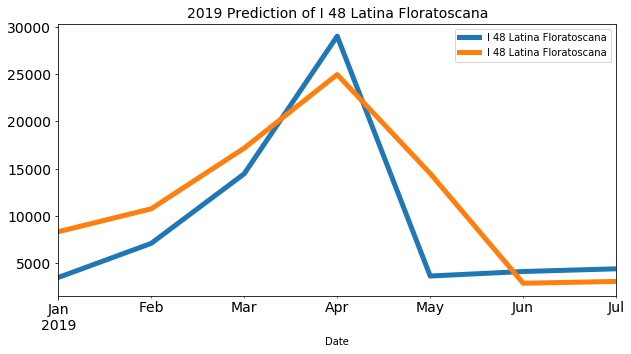

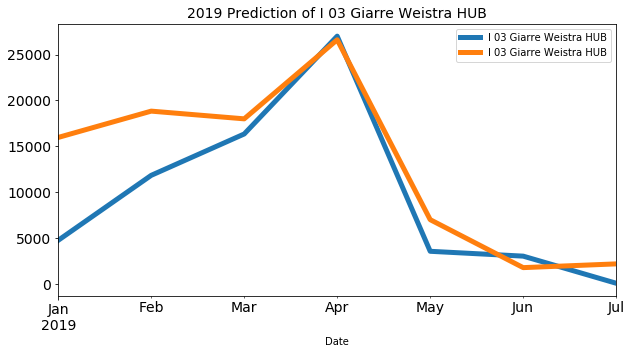

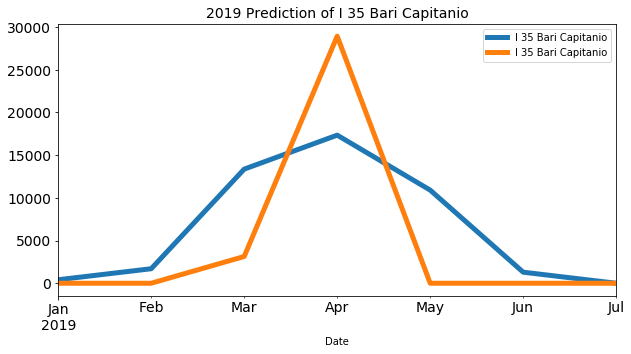

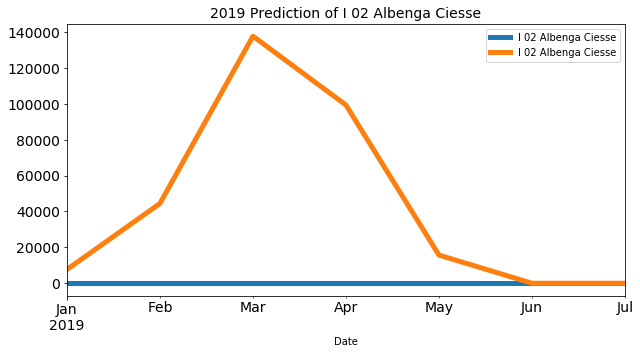

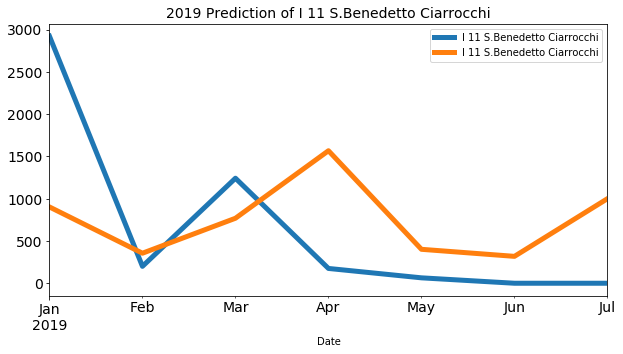

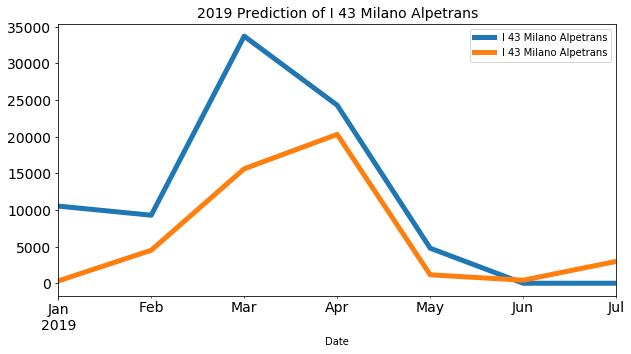

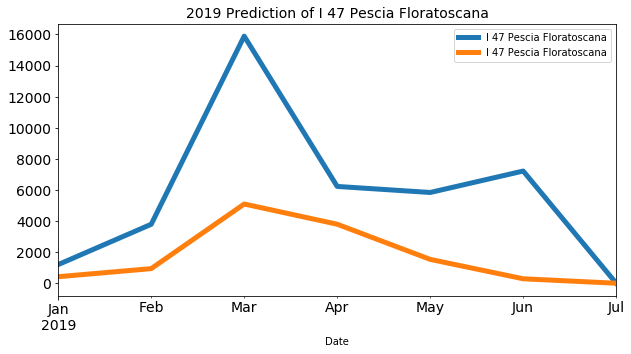

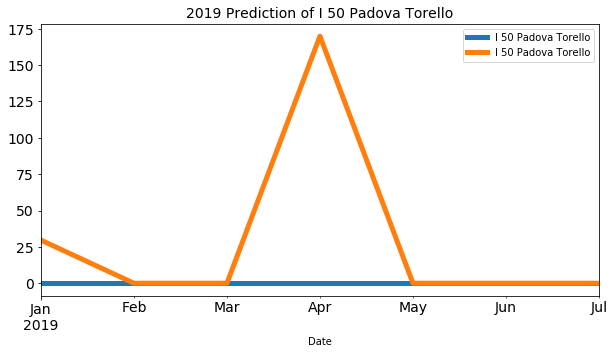

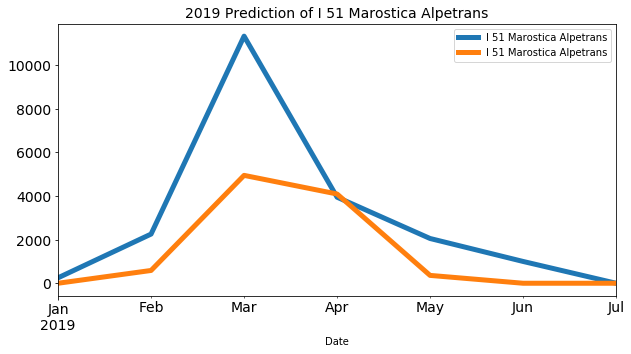

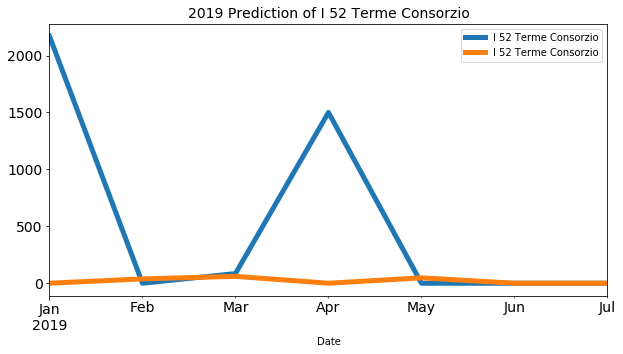

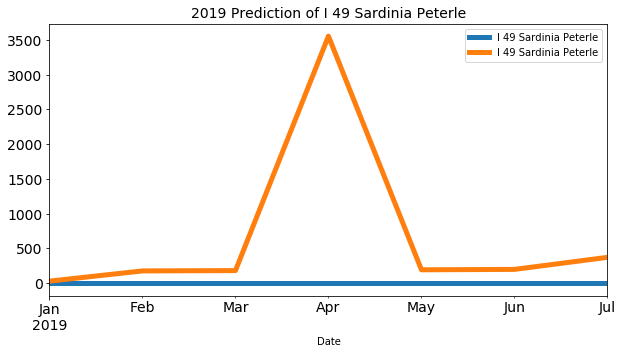

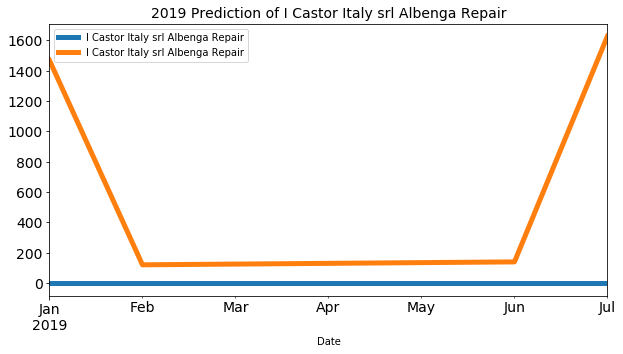

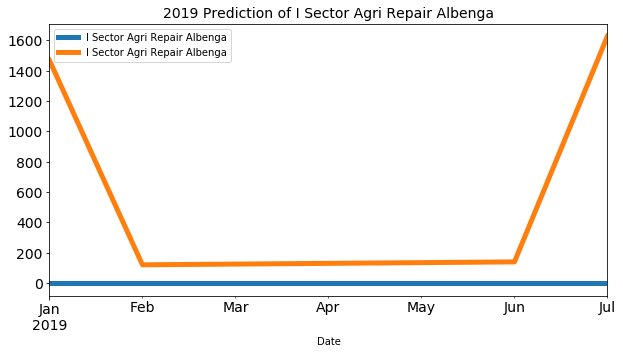

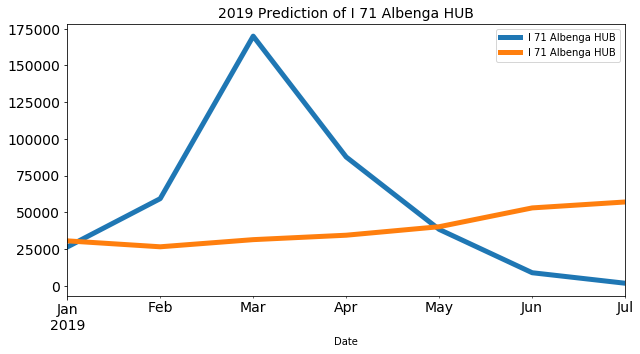

In [61]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [62]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

[0.002984121534943608,
 0.0032243723559309207,
 0.00596992078961869,
 0.5116160106819184,
 0.00012314009915691485,
 0.008118114426341506,
 0.003253221253336955,
 4.892809938069717e-07,
 0.0007823907050279297,
 0.00011459454332955642,
 0.0002126505533292004,
 8.046014815206947e-05,
 8.046014815206947e-05,
 0.46344005347976813]

In [63]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

Normalized MSE of depots: 

 I 48 Latina Floratoscana : 0.002984121534943608

 I 03 Giarre Weistra HUB : 0.0032243723559309207

 I 35 Bari Capitanio : 0.00596992078961869

 I 02 Albenga Ciesse : 0.5116160106819184

 I 11 S.Benedetto Ciarrocchi : 0.00012314009915691485

 I 43 Milano Alpetrans : 0.008118114426341506

 I 47 Pescia Floratoscana : 0.003253221253336955

 I 50 Padova Torello : 4.892809938069717e-07

 I 51 Marostica Alpetrans : 0.0007823907050279297

 I 52 Terme Consorzio : 0.00011459454332955642

 I 49 Sardinia Peterle : 0.0002126505533292004

 I Castor Italy srl Albenga Repair : 8.046014815206947e-05

 I Sector Agri Repair Albenga : 8.046014815206947e-05

 I 71 Albenga HUB : 0.46344005347976813

 the MOST accurate : I 50 Padova Torello

 the LEAST accurate: I 02 Albenga Ciesse


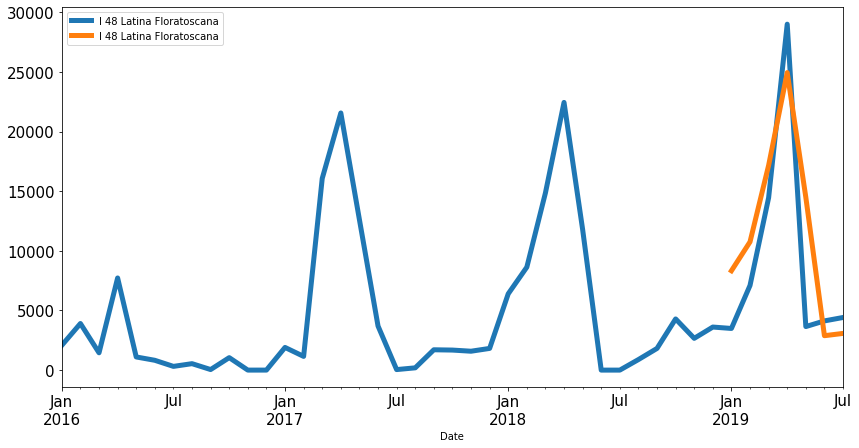

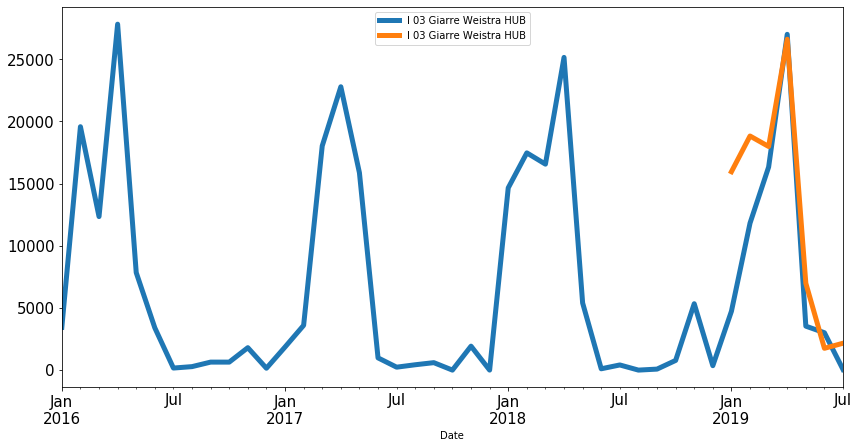

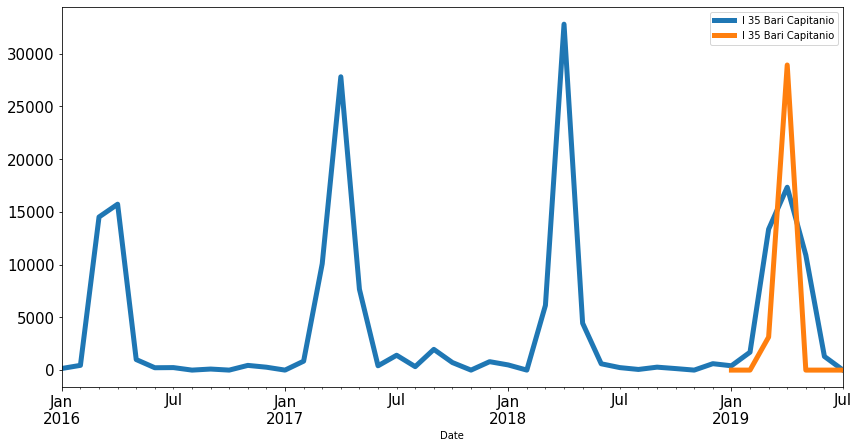

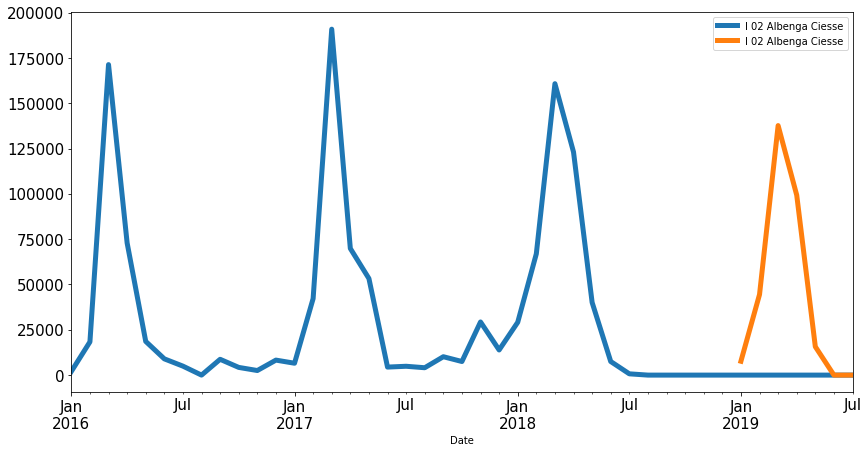

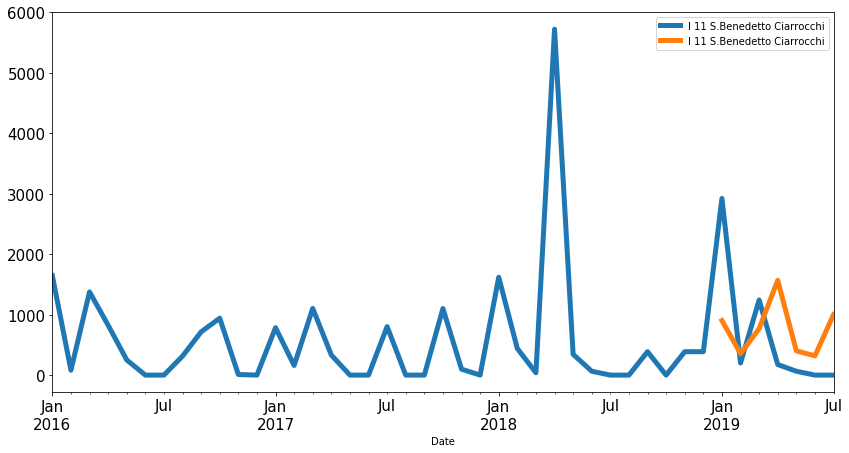

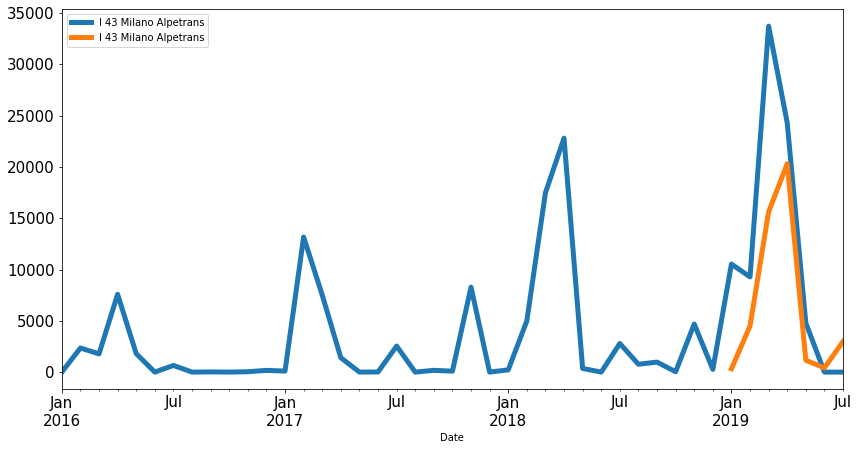

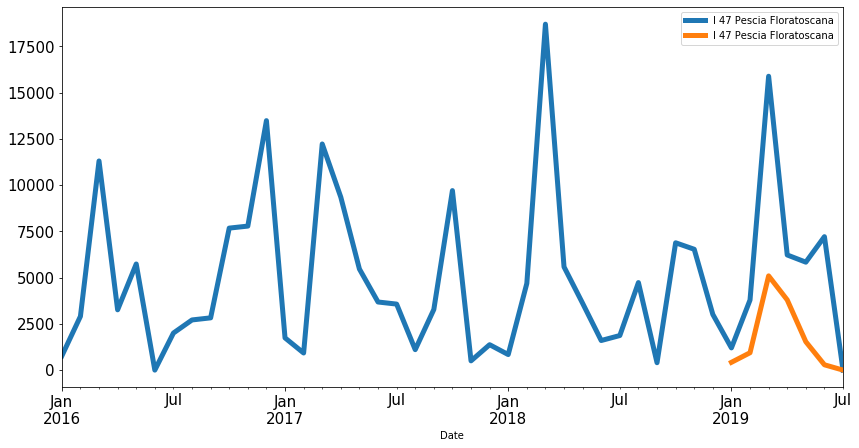

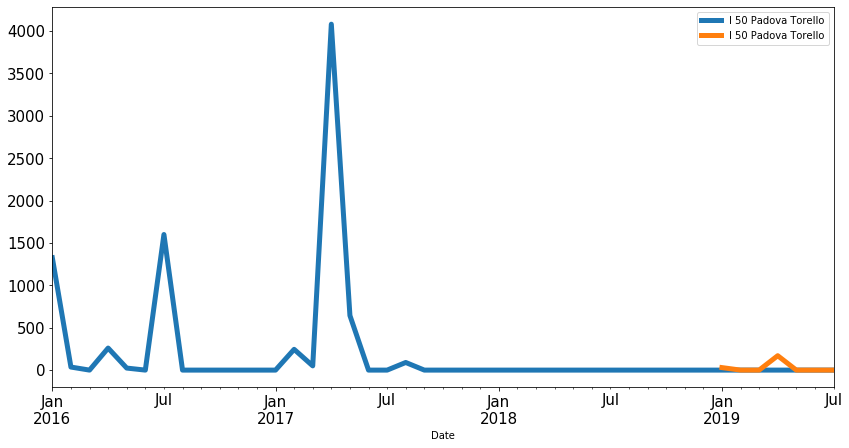

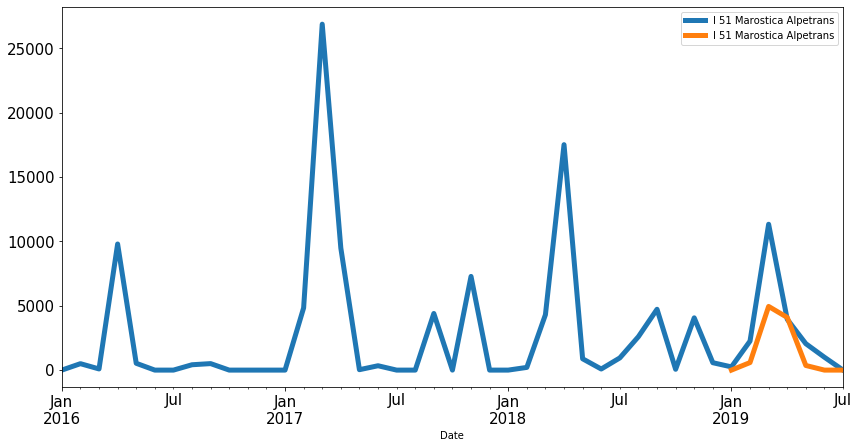

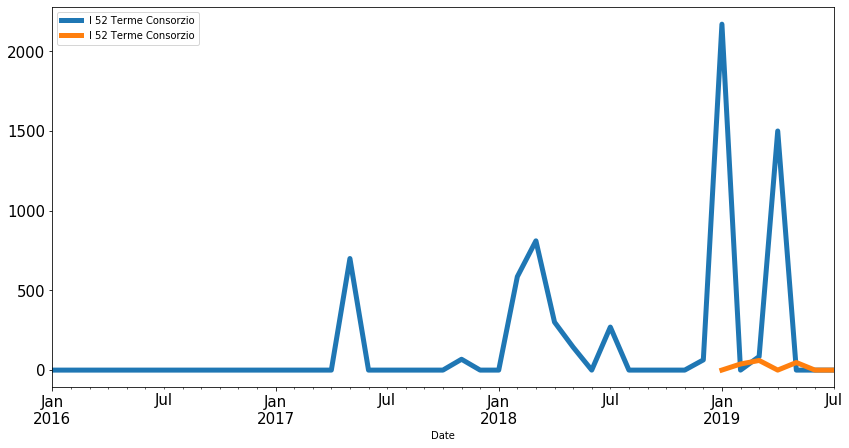

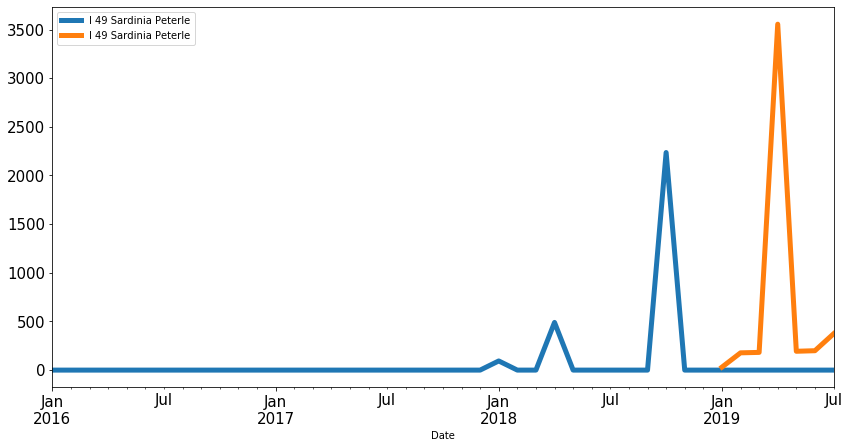

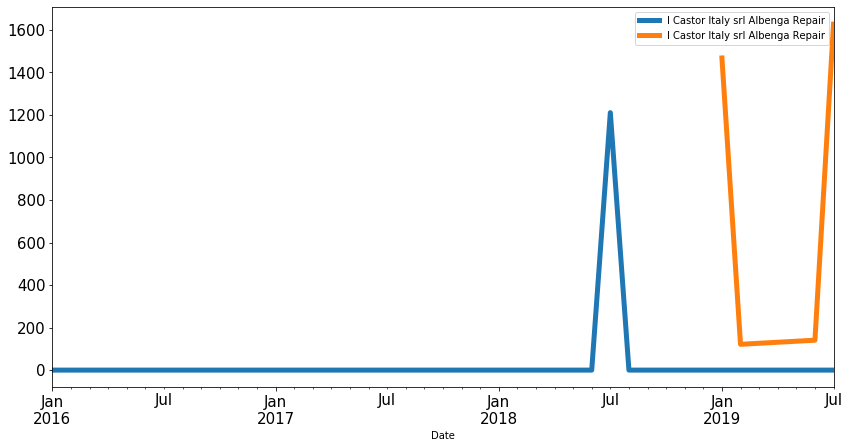

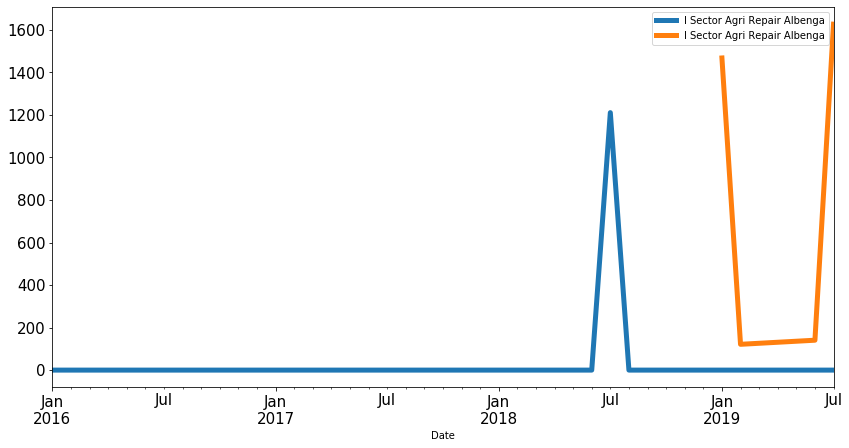

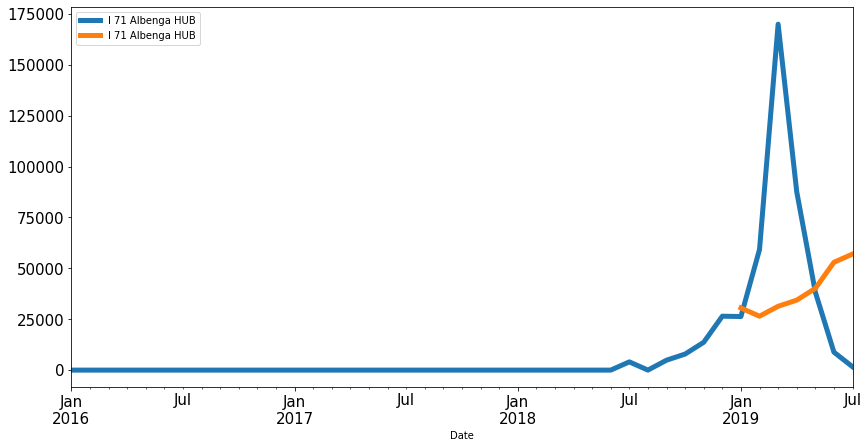

In [64]:
for s in range(0, len(depos)):
    pd.concat([it_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

In [65]:
#it_cb2016['I 48 Latina Floratoscana']

## Implementing SVM and Kernel SVM with Python's Scikit-Learn

In [66]:
it_cb2016

name,I 02 Albenga Ciesse,I 03 Giarre Weistra HUB,I 11 S.Benedetto Ciarrocchi,I 35 Bari Capitanio,I 43 Milano Alpetrans,I 47 Pescia Floratoscana,I 48 Latina Floratoscana,I 49 Sardinia Peterle,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 71 Albenga HUB,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga
Date,,,,,,,,,,,,,,
2016-01-31,2013,3441,1645,154,0,765,2080,0,1326,0,0,0,0,0
2016-02-29,18342,19577,81,450,2352,2907,3905,0,36,500,0,0,0,0
2016-03-31,171286,12347,1376,14520,1775,11307,1450,0,0,90,0,0,0,0
2016-04-30,72917,27822,826,15733,7586,3260,7724,0,260,9802,0,0,0,0
2016-05-31,18592,7842,251,1000,1800,5737,1102,0,24,530,0,0,0,0
2016-06-30,8966,3400,0,224,0,0,822,0,0,0,0,0,0,0
2016-07-31,4950,165,0,238,650,2004,312,0,1600,0,0,0,0,0
2016-08-31,0,280,314,0,0,2712,540,0,0,416,0,0,0,0
2016-09-30,8718,643,715,100,18,2825,46,0,0,505,0,0,0,0


In [67]:
X = it_cb2016.drop('I 02 Albenga Ciesse', axis=1)
y = it_cb2016['I 02 Albenga Ciesse']

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [69]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
y_pred = svclassifier.predict(X_test)

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
        2528       0.00      0.00      0.00         1
        4247       0.00      0.00      0.00         0
        4421       0.00      0.00      0.00         0
        4950       0.00      0.00      0.00         1
        7506       0.00      0.00      0.00         0
       18342       0.00      0.00      0.00         1
       29314       0.00      0.00      0.00         0
       40085       0.00      0.00      0.00         1
       42210       0.00      0.00      0.00         1
       66913       0.00    

## Regression Analysis with StatsModel

In [72]:
import statsmodels.api as sm

In [73]:
XVar = it_cb2016.drop('I 47 Pescia Floratoscana', axis = 1)
YVar = it_cb2016['I 47 Pescia Floratoscana']
YVar.head()

Date
2016-01-31      765
2016-02-29     2907
2016-03-31    11307
2016-04-30     3260
2016-05-31     5737
Freq: M, Name: I 47 Pescia Floratoscana, dtype: int64

In [74]:
XVar.head()

name,I 02 Albenga Ciesse,I 03 Giarre Weistra HUB,I 11 S.Benedetto Ciarrocchi,I 35 Bari Capitanio,I 43 Milano Alpetrans,I 48 Latina Floratoscana,I 49 Sardinia Peterle,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 71 Albenga HUB,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga
Date,,,,,,,,,,,,,
2016-01-31,2013,3441,1645,154,0,2080,0,1326,0,0,0,0,0
2016-02-29,18342,19577,81,450,2352,3905,0,36,500,0,0,0,0
2016-03-31,171286,12347,1376,14520,1775,1450,0,0,90,0,0,0,0
2016-04-30,72917,27822,826,15733,7586,7724,0,260,9802,0,0,0,0
2016-05-31,18592,7842,251,1000,1800,1102,0,24,530,0,0,0,0


In [75]:
linearModel = sm.OLS(YVar, XVar).fit()

In [76]:
print(linearModel.summary())

                                    OLS Regression Results                                   
Dep. Variable:     I 47 Pescia Floratoscana   R-squared (uncentered):                   0.688
Model:                                  OLS   Adj. R-squared (uncentered):              0.568
Method:                       Least Squares   F-statistic:                              5.704
Date:                      Sun, 22 Mar 2020   Prob (F-statistic):                    4.51e-05
Time:                              11:57:55   Log-Likelihood:                         -413.79
No. Observations:                        43   AIC:                                      851.6
Df Residuals:                            31   BIC:                                      872.7
Df Model:                                12                                                  
Covariance Type:                  nonrobust                                                  
                                        coef    std err     

In [77]:
X_sig = it_cb2016.drop(['I 47 Pescia Floratoscana', 'I 03 Giarre Weistra HUB', 'I 11 S.Benedetto Ciarrocchi', 'I 35 Bari Capitanio', 'I 43 Milano Alpetrans', 'I 48 Latina Floratoscana', 'I 49 Sardinia Peterle', 'I 50 Padova Torello', 'I 51 Marostica Alpetrans', 'I 52 Terme Consorzio', 'I Castor Italy srl Albenga Repair', 'I Sector Agri Repair Albenga'], axis = 1)

In [78]:
linearModel1 = sm.OLS(YVar, X_sig).fit()

In [79]:
print(linearModel1.summary())

                                    OLS Regression Results                                   
Dep. Variable:     I 47 Pescia Floratoscana   R-squared (uncentered):                   0.636
Model:                                  OLS   Adj. R-squared (uncentered):              0.619
Method:                       Least Squares   F-statistic:                              35.87
Date:                      Sun, 22 Mar 2020   Prob (F-statistic):                    9.87e-10
Time:                              11:57:55   Log-Likelihood:                         -417.11
No. Observations:                        43   AIC:                                      838.2
Df Residuals:                            41   BIC:                                      841.7
Df Model:                                 2                                                  
Covariance Type:                  nonrobust                                                  
                          coef    std err          t      P>

In [80]:
XVar2 = sm.add_constant(X_sig)

In [81]:
linearModel2 = sm.OLS(YVar, XVar2).fit()

In [82]:
print(linearModel2.summary())

                               OLS Regression Results                               
Dep. Variable:     I 47 Pescia Floratoscana   R-squared:                       0.434
Model:                                  OLS   Adj. R-squared:                  0.405
Method:                       Least Squares   F-statistic:                     15.31
Date:                      Sun, 22 Mar 2020   Prob (F-statistic):           1.16e-05
Time:                              11:57:55   Log-Likelihood:                -408.65
No. Observations:                        43   AIC:                             823.3
Df Residuals:                            40   BIC:                             828.6
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [83]:
XVar3 = sm.add_constant(XVar)

In [84]:
linearModel3 = sm.OLS(YVar, XVar3).fit()

In [85]:
print(linearModel3.summary())

                               OLS Regression Results                               
Dep. Variable:     I 47 Pescia Floratoscana   R-squared:                       0.525
Model:                                  OLS   Adj. R-squared:                  0.335
Method:                       Least Squares   F-statistic:                     2.767
Date:                      Sun, 22 Mar 2020   Prob (F-statistic):             0.0117
Time:                              11:57:55   Log-Likelihood:                -404.85
No. Observations:                        43   AIC:                             835.7
Df Residuals:                            30   BIC:                             858.6
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [86]:
it_cb2016.head()

name,I 02 Albenga Ciesse,I 03 Giarre Weistra HUB,I 11 S.Benedetto Ciarrocchi,I 35 Bari Capitanio,I 43 Milano Alpetrans,I 47 Pescia Floratoscana,I 48 Latina Floratoscana,I 49 Sardinia Peterle,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 71 Albenga HUB,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga
Date,,,,,,,,,,,,,,
2016-01-31,2013,3441,1645,154,0,765,2080,0,1326,0,0,0,0,0
2016-02-29,18342,19577,81,450,2352,2907,3905,0,36,500,0,0,0,0
2016-03-31,171286,12347,1376,14520,1775,11307,1450,0,0,90,0,0,0,0
2016-04-30,72917,27822,826,15733,7586,3260,7724,0,260,9802,0,0,0,0
2016-05-31,18592,7842,251,1000,1800,5737,1102,0,24,530,0,0,0,0


In [87]:
it_cb2016['02 + 71'] = it_cb2016['I 02 Albenga Ciesse'] + it_cb2016['I 71 Albenga HUB']

In [88]:
it_cb2016.head()

name,I 02 Albenga Ciesse,I 03 Giarre Weistra HUB,I 11 S.Benedetto Ciarrocchi,I 35 Bari Capitanio,I 43 Milano Alpetrans,I 47 Pescia Floratoscana,I 48 Latina Floratoscana,I 49 Sardinia Peterle,I 50 Padova Torello,I 51 Marostica Alpetrans,I 52 Terme Consorzio,I 71 Albenga HUB,I Castor Italy srl Albenga Repair,I Sector Agri Repair Albenga,02 + 71
Date,,,,,,,,,,,,,,,
2016-01-31,2013,3441,1645,154,0,765,2080,0,1326,0,0,0,0,0,2013
2016-02-29,18342,19577,81,450,2352,2907,3905,0,36,500,0,0,0,0,18342
2016-03-31,171286,12347,1376,14520,1775,11307,1450,0,0,90,0,0,0,0,171286
2016-04-30,72917,27822,826,15733,7586,3260,7724,0,260,9802,0,0,0,0,72917
2016-05-31,18592,7842,251,1000,1800,5737,1102,0,24,530,0,0,0,0,18592


In [89]:
X4 = it_cb2016['02 + 71']

In [90]:
X4.head()

Date
2016-01-31      2013
2016-02-29     18342
2016-03-31    171286
2016-04-30     72917
2016-05-31     18592
Freq: M, Name: 02 + 71, dtype: int64

In [91]:
linearModel4 = sm.OLS(YVar, X4).fit()

In [92]:
print(linearModel4.summary())

                                    OLS Regression Results                                   
Dep. Variable:     I 47 Pescia Floratoscana   R-squared (uncentered):                   0.633
Model:                                  OLS   Adj. R-squared (uncentered):              0.624
Method:                       Least Squares   F-statistic:                              72.30
Date:                      Sun, 22 Mar 2020   Prob (F-statistic):                    1.12e-10
Time:                              11:57:55   Log-Likelihood:                         -417.33
No. Observations:                        43   AIC:                                      836.7
Df Residuals:                            42   BIC:                                      838.4
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
                 coef    std err          t      P>|t|      

In [93]:
dep_X4 = X4.dropna()
print('\n ' + '02 + 71' + ': ')
print('\n')
opt_sarima_X4 = optimal_sarima(dep_X4)
print(opt_sarima.aic())


 02 + 71: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=891.833, BIC=899.751, Fit time=0.192 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=909.662, BIC=912.829, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=821.636, BIC=827.970, Fit time=0.080 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=890.023, BIC=896.357, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=908.269, BIC=909.853, Fit time=0.004 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=911.826, BIC=916.576, Fit time=0.012 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=879.371, BIC=887.289, Fit time=0.080 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=833.259, BIC=839.593, Fit time=0.

In [94]:
X4_train = dep.loc['2016-01-31':'2018-12-31']
X4_test = dep.loc['2019-01-31':]

modelX4_fit = opt_sarima_X4.fit(X4_train)

X4_forecast = modelX4_fit.predict(n_periods=7)

for col in range(len(X4_forecast)):
    if X4_forecast[col] < 0:
        X4_forecast[col] = 0

In [95]:
X4_test

name,I 71 Albenga HUB
Date,
2019-01-31,26323
2019-02-28,59259
2019-03-31,169939
2019-04-30,87639
2019-05-31,38320
2019-06-30,8811
2019-07-31,1649


In [96]:
X4_forecast = pd.DataFrame(X4_forecast)

In [97]:
X4_forecast['Date'] = X4_test.index
X4_forecast = X4_forecast.set_index('Date')
X4_forecast

,0
Date,
2019-01-31,34283.598219
2019-02-28,31532.355936
2019-03-31,37209.974363
2019-04-30,41137.849504
2019-05-31,47685.134822
2019-06-30,60877.470091
2019-07-31,69287.788809


In [98]:
X4_forecast

,0
Date,
2019-01-31,34283.598219
2019-02-28,31532.355936
2019-03-31,37209.974363
2019-04-30,41137.849504
2019-05-31,47685.134822
2019-06-30,60877.470091
2019-07-31,69287.788809


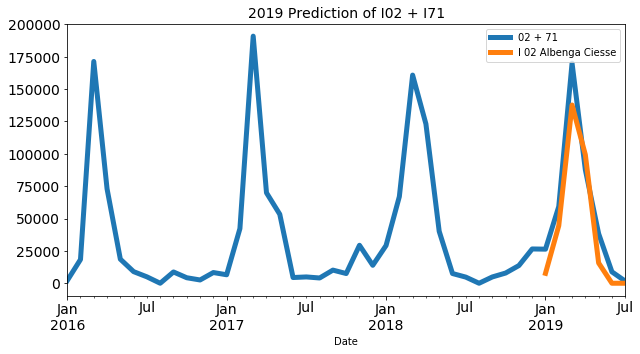

In [99]:
plot_depo_prediction('I02 + I71', it_cb2016['02 + 71'], depots_forecasts[[depos[3]]])

In [100]:
#pd.concat([X4_test], [X4_forecast], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
#plt.title('2019 Prediction of ' + depo_name, fontsize = 14) 

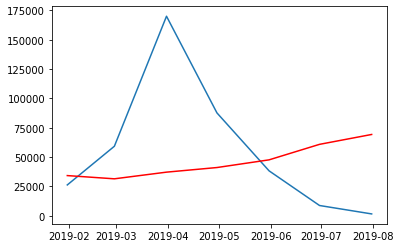

In [101]:
plt.plot(X4_test)
plt.plot(X4_forecast, color = 'red')

In [102]:
it_cb2016['new_I47'] = it_cb2016['02 + 71'] * 0.0818

In [103]:
#pred_new = pd.DataFrame()

In [104]:
pred_new.plot()
plt.plot(it_cb2016['I 47 Pescia Floratoscana'], color = 'red')

NameError: name 'pred_new' is not defined

In [ ]:
plot_depo_prediction('I02 + I71', it_cb2016['I 47 Pescia Floratoscana'], it_cb2016['new_I47'])